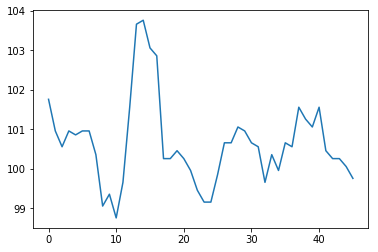

In [1]:
# Imports
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
%matplotlib inline 

# 加载数据
path = "./dataSets/train-test.csv"
# skipfooter=3
dataset = pd.read_csv(path, usecols=[1])
dataset = np.array(dataset)
plt.plot(dataset)
plt.show()

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataSet = scaler.fit_transform(dataset)

# split into train and test sets; 80% 是训练数据，其余是测试数据
train_size = int(len(dataSet) * 0.8)
test_size = len(dataSet) - train_size
train, test = dataSet[0:train_size], dataSet[train_size:len(dataSet)]

In [2]:
# 数据格式转化(t,t+1)
def convert_data(data, time_step=1):
    data_X,data_Y = [],[]  
    for i in range(len(data) - time_step - 1):
        x = data[i: (i + time_step)]  
        y = data[i+1:i + time_step+1]      
        data_X.append(x.tolist())
        data_Y.append(y.tolist()) 
    return data_X, data_Y

# fix random seed for reproducibility
np.random.seed(7)

# use this function to prepare the train and test datasets for modeling
#time_step=5
time_step = 5     #时间步
train_x, train_y = convert_data(train, time_step)
test_x, test_y = convert_data(test, time_step)

In [3]:
#———————————————————形成训练集—————————————————————
#设置常量
hidden_unit = 5       #hidden layer units 记忆和储存过去状态的节点个数
batch_size = 4    #每一批次训练多少个样例
input_size = 1      #输入层维度
output_size = 1     #输出层维度
lr = 0.0001       #学习率

In [4]:
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print("tensorflow运行版本：" + tf.__version__)

# LSTM 的 X 需要有这样的结构： [samples, time steps, features]，所以做一下变换
with tf.name_scope('inputs'):
    X = tf.placeholder(tf.float32, [None,time_step,input_size])    #每批次输入网络的tensor
    Y = tf.placeholder(tf.float32, [None,time_step,output_size])   #每批次tensor对应的标签
# 输入层、输出层权重、偏置
with tf.name_scope('layer'):
        with tf.name_scope('weights'):
            weights={
                     'in':tf.Variable(tf.random_normal([input_size,hidden_unit])),
                     'out':tf.Variable(tf.random_normal([hidden_unit,1]))
                     }
        with tf.name_scope('biases'):
            biases={
                    'in':tf.Variable(tf.constant(0.1,shape=[hidden_unit,])),
                    'out':tf.Variable(tf.constant(0.1,shape=[1,]))
                    }

tensorflow运行版本：1.3.0


In [5]:
def lstm(batch):  #参数：输入网络批次数目

  
    w_in = weights['in']
    b_in = biases['in']
    input = tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
    with tf.variable_scope(tf.get_variable_scope()) as scope:
        
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_unit) #10个节点
        input_lstm = tf.matmul(input, w_in) + b_in
        input_lstm = tf.reshape(input_lstm, [-1, time_step, hidden_unit])  #将tensor转成3维，作为lstm cell的输入      
        print(input_lstm)
        init_state = lstm_cell.zero_state(batch,dtype = tf.float32)
        # output_rnn是记录lstm每个隐状态输出节点的结果，final_states是最后一个cell的结果，数据格式为tuple
        output_rnn, final_states = tf.nn.dynamic_rnn(
            lstm_cell, 
            input_lstm, 
            initial_state = init_state, 
            dtype = tf.float32) 
        
        output = tf.reshape(output_rnn, [-1, hidden_unit]) #  作为输出层的输入
        w_out = weights['out']
        b_out = biases['out']
        #matmul做矩阵乘法
        pred = tf.matmul(output, w_out) + b_out
        return pred, final_states

In [6]:
train_loss = []
def train_lstm():   
    global batch_size
    iteration = 1
    epochs = 10000
    log_dir = './predict_logs'
    with tf.variable_scope("rnn"):
        pred, _ = lstm(batch_size)
    # 损失函数
    loss = tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    #tf.summary.scalar('loss_function', loss)
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)
    saver = tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        keep_prob = tf.placeholder(tf.float32)
        sess.run(tf.global_variables_initializer())
        # summaries合并
        #merged = tf.summary.merge_all()    
        # 写到指定的磁盘路径中
        #train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
        # 重复训练5000次
        for e in range(epochs):
            step=0
            start = 0
            end = start + batch_size
            while(end < len(train_x)):
                x = train_x[start:end]
                y = train_y[start:end]
                _,loss_ = sess.run([train_op, loss], feed_dict = {X: x, Y:y, keep_prob : 0.3})
                start += batch_size
                end = start + batch_size
                # 每10步保存一次参数
                if step% 10 == 0:                    
                    print("Epoch: {}/{}".format(e, epochs),
                    "Iteration: {:d}".format(iteration),
                    "Train loss: {:6f}".format(loss_))
                    #train_writer.add_summary(summary, e);

                train_loss.append(loss_)
                iteration += 1  
                step += 1
        saver.save(sess, "checkpoints-lstm/predict.ckpt")
        #绘训练过程指标图
        t = np.arange(iteration - 1)
        plt.figure(figsize = (9,6))
        plt.plot(t, np.array(train_loss),  'r-')
        plt.xlabel("iteration")
        plt.ylabel("Loss")
        plt.legend(['train'], loc='upper right')
        plt.show()        

Tensor("rnn_1/rnn/rnn/Reshape:0", shape=(?, 5, 5), dtype=float32)
Epoch: 0/10000 Iteration: 1 Train loss: 0.148118
Epoch: 1/10000 Iteration: 8 Train loss: 0.142498
Epoch: 2/10000 Iteration: 15 Train loss: 0.137152
Epoch: 3/10000 Iteration: 22 Train loss: 0.131953
Epoch: 4/10000 Iteration: 29 Train loss: 0.126902
Epoch: 5/10000 Iteration: 36 Train loss: 0.122004
Epoch: 6/10000 Iteration: 43 Train loss: 0.117260
Epoch: 7/10000 Iteration: 50 Train loss: 0.112671
Epoch: 8/10000 Iteration: 57 Train loss: 0.108236
Epoch: 9/10000 Iteration: 64 Train loss: 0.103952
Epoch: 10/10000 Iteration: 71 Train loss: 0.099818
Epoch: 11/10000 Iteration: 78 Train loss: 0.095831
Epoch: 12/10000 Iteration: 85 Train loss: 0.091987
Epoch: 13/10000 Iteration: 92 Train loss: 0.088285
Epoch: 14/10000 Iteration: 99 Train loss: 0.084720
Epoch: 15/10000 Iteration: 106 Train loss: 0.081289
Epoch: 16/10000 Iteration: 113 Train loss: 0.077990
Epoch: 17/10000 Iteration: 120 Train loss: 0.074820
Epoch: 18/10000 Iteration

Epoch: 156/10000 Iteration: 1093 Train loss: 0.013363
Epoch: 157/10000 Iteration: 1100 Train loss: 0.013325
Epoch: 158/10000 Iteration: 1107 Train loss: 0.013288
Epoch: 159/10000 Iteration: 1114 Train loss: 0.013251
Epoch: 160/10000 Iteration: 1121 Train loss: 0.013213
Epoch: 161/10000 Iteration: 1128 Train loss: 0.013175
Epoch: 162/10000 Iteration: 1135 Train loss: 0.013138
Epoch: 163/10000 Iteration: 1142 Train loss: 0.013100
Epoch: 164/10000 Iteration: 1149 Train loss: 0.013062
Epoch: 165/10000 Iteration: 1156 Train loss: 0.013024
Epoch: 166/10000 Iteration: 1163 Train loss: 0.012987
Epoch: 167/10000 Iteration: 1170 Train loss: 0.012949
Epoch: 168/10000 Iteration: 1177 Train loss: 0.012911
Epoch: 169/10000 Iteration: 1184 Train loss: 0.012873
Epoch: 170/10000 Iteration: 1191 Train loss: 0.012835
Epoch: 171/10000 Iteration: 1198 Train loss: 0.012797
Epoch: 172/10000 Iteration: 1205 Train loss: 0.012760
Epoch: 173/10000 Iteration: 1212 Train loss: 0.012722
Epoch: 174/10000 Iteration: 

Epoch: 311/10000 Iteration: 2178 Train loss: 0.008259
Epoch: 312/10000 Iteration: 2185 Train loss: 0.008234
Epoch: 313/10000 Iteration: 2192 Train loss: 0.008209
Epoch: 314/10000 Iteration: 2199 Train loss: 0.008184
Epoch: 315/10000 Iteration: 2206 Train loss: 0.008159
Epoch: 316/10000 Iteration: 2213 Train loss: 0.008134
Epoch: 317/10000 Iteration: 2220 Train loss: 0.008110
Epoch: 318/10000 Iteration: 2227 Train loss: 0.008086
Epoch: 319/10000 Iteration: 2234 Train loss: 0.008061
Epoch: 320/10000 Iteration: 2241 Train loss: 0.008037
Epoch: 321/10000 Iteration: 2248 Train loss: 0.008013
Epoch: 322/10000 Iteration: 2255 Train loss: 0.007989
Epoch: 323/10000 Iteration: 2262 Train loss: 0.007966
Epoch: 324/10000 Iteration: 2269 Train loss: 0.007942
Epoch: 325/10000 Iteration: 2276 Train loss: 0.007918
Epoch: 326/10000 Iteration: 2283 Train loss: 0.007895
Epoch: 327/10000 Iteration: 2290 Train loss: 0.007872
Epoch: 328/10000 Iteration: 2297 Train loss: 0.007848
Epoch: 329/10000 Iteration: 

Epoch: 464/10000 Iteration: 3249 Train loss: 0.005778
Epoch: 465/10000 Iteration: 3256 Train loss: 0.005771
Epoch: 466/10000 Iteration: 3263 Train loss: 0.005764
Epoch: 467/10000 Iteration: 3270 Train loss: 0.005757
Epoch: 468/10000 Iteration: 3277 Train loss: 0.005750
Epoch: 469/10000 Iteration: 3284 Train loss: 0.005743
Epoch: 470/10000 Iteration: 3291 Train loss: 0.005736
Epoch: 471/10000 Iteration: 3298 Train loss: 0.005729
Epoch: 472/10000 Iteration: 3305 Train loss: 0.005722
Epoch: 473/10000 Iteration: 3312 Train loss: 0.005716
Epoch: 474/10000 Iteration: 3319 Train loss: 0.005709
Epoch: 475/10000 Iteration: 3326 Train loss: 0.005703
Epoch: 476/10000 Iteration: 3333 Train loss: 0.005697
Epoch: 477/10000 Iteration: 3340 Train loss: 0.005691
Epoch: 478/10000 Iteration: 3347 Train loss: 0.005685
Epoch: 479/10000 Iteration: 3354 Train loss: 0.005679
Epoch: 480/10000 Iteration: 3361 Train loss: 0.005673
Epoch: 481/10000 Iteration: 3368 Train loss: 0.005667
Epoch: 482/10000 Iteration: 

Epoch: 619/10000 Iteration: 4334 Train loss: 0.005679
Epoch: 620/10000 Iteration: 4341 Train loss: 0.005683
Epoch: 621/10000 Iteration: 4348 Train loss: 0.005687
Epoch: 622/10000 Iteration: 4355 Train loss: 0.005691
Epoch: 623/10000 Iteration: 4362 Train loss: 0.005695
Epoch: 624/10000 Iteration: 4369 Train loss: 0.005700
Epoch: 625/10000 Iteration: 4376 Train loss: 0.005704
Epoch: 626/10000 Iteration: 4383 Train loss: 0.005708
Epoch: 627/10000 Iteration: 4390 Train loss: 0.005712
Epoch: 628/10000 Iteration: 4397 Train loss: 0.005717
Epoch: 629/10000 Iteration: 4404 Train loss: 0.005721
Epoch: 630/10000 Iteration: 4411 Train loss: 0.005726
Epoch: 631/10000 Iteration: 4418 Train loss: 0.005730
Epoch: 632/10000 Iteration: 4425 Train loss: 0.005734
Epoch: 633/10000 Iteration: 4432 Train loss: 0.005739
Epoch: 634/10000 Iteration: 4439 Train loss: 0.005743
Epoch: 635/10000 Iteration: 4446 Train loss: 0.005748
Epoch: 636/10000 Iteration: 4453 Train loss: 0.005752
Epoch: 637/10000 Iteration: 

Epoch: 771/10000 Iteration: 5398 Train loss: 0.006391
Epoch: 772/10000 Iteration: 5405 Train loss: 0.006395
Epoch: 773/10000 Iteration: 5412 Train loss: 0.006399
Epoch: 774/10000 Iteration: 5419 Train loss: 0.006403
Epoch: 775/10000 Iteration: 5426 Train loss: 0.006407
Epoch: 776/10000 Iteration: 5433 Train loss: 0.006411
Epoch: 777/10000 Iteration: 5440 Train loss: 0.006414
Epoch: 778/10000 Iteration: 5447 Train loss: 0.006418
Epoch: 779/10000 Iteration: 5454 Train loss: 0.006422
Epoch: 780/10000 Iteration: 5461 Train loss: 0.006426
Epoch: 781/10000 Iteration: 5468 Train loss: 0.006430
Epoch: 782/10000 Iteration: 5475 Train loss: 0.006434
Epoch: 783/10000 Iteration: 5482 Train loss: 0.006437
Epoch: 784/10000 Iteration: 5489 Train loss: 0.006441
Epoch: 785/10000 Iteration: 5496 Train loss: 0.006445
Epoch: 786/10000 Iteration: 5503 Train loss: 0.006449
Epoch: 787/10000 Iteration: 5510 Train loss: 0.006452
Epoch: 788/10000 Iteration: 5517 Train loss: 0.006456
Epoch: 789/10000 Iteration: 

Epoch: 925/10000 Iteration: 6476 Train loss: 0.006813
Epoch: 926/10000 Iteration: 6483 Train loss: 0.006815
Epoch: 927/10000 Iteration: 6490 Train loss: 0.006817
Epoch: 928/10000 Iteration: 6497 Train loss: 0.006819
Epoch: 929/10000 Iteration: 6504 Train loss: 0.006821
Epoch: 930/10000 Iteration: 6511 Train loss: 0.006822
Epoch: 931/10000 Iteration: 6518 Train loss: 0.006824
Epoch: 932/10000 Iteration: 6525 Train loss: 0.006826
Epoch: 933/10000 Iteration: 6532 Train loss: 0.006827
Epoch: 934/10000 Iteration: 6539 Train loss: 0.006829
Epoch: 935/10000 Iteration: 6546 Train loss: 0.006831
Epoch: 936/10000 Iteration: 6553 Train loss: 0.006832
Epoch: 937/10000 Iteration: 6560 Train loss: 0.006834
Epoch: 938/10000 Iteration: 6567 Train loss: 0.006836
Epoch: 939/10000 Iteration: 6574 Train loss: 0.006838
Epoch: 940/10000 Iteration: 6581 Train loss: 0.006839
Epoch: 941/10000 Iteration: 6588 Train loss: 0.006841
Epoch: 942/10000 Iteration: 6595 Train loss: 0.006842
Epoch: 943/10000 Iteration: 

Epoch: 1080/10000 Iteration: 7561 Train loss: 0.007022
Epoch: 1081/10000 Iteration: 7568 Train loss: 0.007023
Epoch: 1082/10000 Iteration: 7575 Train loss: 0.007024
Epoch: 1083/10000 Iteration: 7582 Train loss: 0.007025
Epoch: 1084/10000 Iteration: 7589 Train loss: 0.007026
Epoch: 1085/10000 Iteration: 7596 Train loss: 0.007027
Epoch: 1086/10000 Iteration: 7603 Train loss: 0.007028
Epoch: 1087/10000 Iteration: 7610 Train loss: 0.007029
Epoch: 1088/10000 Iteration: 7617 Train loss: 0.007030
Epoch: 1089/10000 Iteration: 7624 Train loss: 0.007031
Epoch: 1090/10000 Iteration: 7631 Train loss: 0.007032
Epoch: 1091/10000 Iteration: 7638 Train loss: 0.007033
Epoch: 1092/10000 Iteration: 7645 Train loss: 0.007034
Epoch: 1093/10000 Iteration: 7652 Train loss: 0.007035
Epoch: 1094/10000 Iteration: 7659 Train loss: 0.007036
Epoch: 1095/10000 Iteration: 7666 Train loss: 0.007038
Epoch: 1096/10000 Iteration: 7673 Train loss: 0.007039
Epoch: 1097/10000 Iteration: 7680 Train loss: 0.007040
Epoch: 109

Epoch: 1232/10000 Iteration: 8625 Train loss: 0.007161
Epoch: 1233/10000 Iteration: 8632 Train loss: 0.007161
Epoch: 1234/10000 Iteration: 8639 Train loss: 0.007162
Epoch: 1235/10000 Iteration: 8646 Train loss: 0.007163
Epoch: 1236/10000 Iteration: 8653 Train loss: 0.007164
Epoch: 1237/10000 Iteration: 8660 Train loss: 0.007164
Epoch: 1238/10000 Iteration: 8667 Train loss: 0.007165
Epoch: 1239/10000 Iteration: 8674 Train loss: 0.007166
Epoch: 1240/10000 Iteration: 8681 Train loss: 0.007167
Epoch: 1241/10000 Iteration: 8688 Train loss: 0.007167
Epoch: 1242/10000 Iteration: 8695 Train loss: 0.007168
Epoch: 1243/10000 Iteration: 8702 Train loss: 0.007169
Epoch: 1244/10000 Iteration: 8709 Train loss: 0.007170
Epoch: 1245/10000 Iteration: 8716 Train loss: 0.007170
Epoch: 1246/10000 Iteration: 8723 Train loss: 0.007171
Epoch: 1247/10000 Iteration: 8730 Train loss: 0.007172
Epoch: 1248/10000 Iteration: 8737 Train loss: 0.007173
Epoch: 1249/10000 Iteration: 8744 Train loss: 0.007173
Epoch: 125

Epoch: 1383/10000 Iteration: 9682 Train loss: 0.007255
Epoch: 1384/10000 Iteration: 9689 Train loss: 0.007255
Epoch: 1385/10000 Iteration: 9696 Train loss: 0.007256
Epoch: 1386/10000 Iteration: 9703 Train loss: 0.007256
Epoch: 1387/10000 Iteration: 9710 Train loss: 0.007257
Epoch: 1388/10000 Iteration: 9717 Train loss: 0.007257
Epoch: 1389/10000 Iteration: 9724 Train loss: 0.007258
Epoch: 1390/10000 Iteration: 9731 Train loss: 0.007258
Epoch: 1391/10000 Iteration: 9738 Train loss: 0.007259
Epoch: 1392/10000 Iteration: 9745 Train loss: 0.007259
Epoch: 1393/10000 Iteration: 9752 Train loss: 0.007259
Epoch: 1394/10000 Iteration: 9759 Train loss: 0.007260
Epoch: 1395/10000 Iteration: 9766 Train loss: 0.007260
Epoch: 1396/10000 Iteration: 9773 Train loss: 0.007261
Epoch: 1397/10000 Iteration: 9780 Train loss: 0.007261
Epoch: 1398/10000 Iteration: 9787 Train loss: 0.007262
Epoch: 1399/10000 Iteration: 9794 Train loss: 0.007262
Epoch: 1400/10000 Iteration: 9801 Train loss: 0.007263
Epoch: 140

Epoch: 1532/10000 Iteration: 10725 Train loss: 0.007300
Epoch: 1533/10000 Iteration: 10732 Train loss: 0.007301
Epoch: 1534/10000 Iteration: 10739 Train loss: 0.007301
Epoch: 1535/10000 Iteration: 10746 Train loss: 0.007301
Epoch: 1536/10000 Iteration: 10753 Train loss: 0.007301
Epoch: 1537/10000 Iteration: 10760 Train loss: 0.007301
Epoch: 1538/10000 Iteration: 10767 Train loss: 0.007301
Epoch: 1539/10000 Iteration: 10774 Train loss: 0.007301
Epoch: 1540/10000 Iteration: 10781 Train loss: 0.007301
Epoch: 1541/10000 Iteration: 10788 Train loss: 0.007302
Epoch: 1542/10000 Iteration: 10795 Train loss: 0.007302
Epoch: 1543/10000 Iteration: 10802 Train loss: 0.007302
Epoch: 1544/10000 Iteration: 10809 Train loss: 0.007302
Epoch: 1545/10000 Iteration: 10816 Train loss: 0.007302
Epoch: 1546/10000 Iteration: 10823 Train loss: 0.007302
Epoch: 1547/10000 Iteration: 10830 Train loss: 0.007302
Epoch: 1548/10000 Iteration: 10837 Train loss: 0.007302
Epoch: 1549/10000 Iteration: 10844 Train loss: 0

Epoch: 1683/10000 Iteration: 11782 Train loss: 0.007298
Epoch: 1684/10000 Iteration: 11789 Train loss: 0.007298
Epoch: 1685/10000 Iteration: 11796 Train loss: 0.007298
Epoch: 1686/10000 Iteration: 11803 Train loss: 0.007297
Epoch: 1687/10000 Iteration: 11810 Train loss: 0.007297
Epoch: 1688/10000 Iteration: 11817 Train loss: 0.007297
Epoch: 1689/10000 Iteration: 11824 Train loss: 0.007297
Epoch: 1690/10000 Iteration: 11831 Train loss: 0.007297
Epoch: 1691/10000 Iteration: 11838 Train loss: 0.007297
Epoch: 1692/10000 Iteration: 11845 Train loss: 0.007296
Epoch: 1693/10000 Iteration: 11852 Train loss: 0.007296
Epoch: 1694/10000 Iteration: 11859 Train loss: 0.007296
Epoch: 1695/10000 Iteration: 11866 Train loss: 0.007296
Epoch: 1696/10000 Iteration: 11873 Train loss: 0.007296
Epoch: 1697/10000 Iteration: 11880 Train loss: 0.007295
Epoch: 1698/10000 Iteration: 11887 Train loss: 0.007295
Epoch: 1699/10000 Iteration: 11894 Train loss: 0.007295
Epoch: 1700/10000 Iteration: 11901 Train loss: 0

Epoch: 1834/10000 Iteration: 12839 Train loss: 0.007256
Epoch: 1835/10000 Iteration: 12846 Train loss: 0.007256
Epoch: 1836/10000 Iteration: 12853 Train loss: 0.007256
Epoch: 1837/10000 Iteration: 12860 Train loss: 0.007255
Epoch: 1838/10000 Iteration: 12867 Train loss: 0.007255
Epoch: 1839/10000 Iteration: 12874 Train loss: 0.007254
Epoch: 1840/10000 Iteration: 12881 Train loss: 0.007254
Epoch: 1841/10000 Iteration: 12888 Train loss: 0.007254
Epoch: 1842/10000 Iteration: 12895 Train loss: 0.007253
Epoch: 1843/10000 Iteration: 12902 Train loss: 0.007253
Epoch: 1844/10000 Iteration: 12909 Train loss: 0.007253
Epoch: 1845/10000 Iteration: 12916 Train loss: 0.007252
Epoch: 1846/10000 Iteration: 12923 Train loss: 0.007252
Epoch: 1847/10000 Iteration: 12930 Train loss: 0.007251
Epoch: 1848/10000 Iteration: 12937 Train loss: 0.007251
Epoch: 1849/10000 Iteration: 12944 Train loss: 0.007251
Epoch: 1850/10000 Iteration: 12951 Train loss: 0.007250
Epoch: 1851/10000 Iteration: 12958 Train loss: 0

Epoch: 1982/10000 Iteration: 13875 Train loss: 0.007196
Epoch: 1983/10000 Iteration: 13882 Train loss: 0.007195
Epoch: 1984/10000 Iteration: 13889 Train loss: 0.007195
Epoch: 1985/10000 Iteration: 13896 Train loss: 0.007194
Epoch: 1986/10000 Iteration: 13903 Train loss: 0.007194
Epoch: 1987/10000 Iteration: 13910 Train loss: 0.007193
Epoch: 1988/10000 Iteration: 13917 Train loss: 0.007193
Epoch: 1989/10000 Iteration: 13924 Train loss: 0.007193
Epoch: 1990/10000 Iteration: 13931 Train loss: 0.007192
Epoch: 1991/10000 Iteration: 13938 Train loss: 0.007192
Epoch: 1992/10000 Iteration: 13945 Train loss: 0.007191
Epoch: 1993/10000 Iteration: 13952 Train loss: 0.007191
Epoch: 1994/10000 Iteration: 13959 Train loss: 0.007190
Epoch: 1995/10000 Iteration: 13966 Train loss: 0.007190
Epoch: 1996/10000 Iteration: 13973 Train loss: 0.007190
Epoch: 1997/10000 Iteration: 13980 Train loss: 0.007189
Epoch: 1998/10000 Iteration: 13987 Train loss: 0.007189
Epoch: 1999/10000 Iteration: 13994 Train loss: 0

Epoch: 2129/10000 Iteration: 14904 Train loss: 0.007137
Epoch: 2130/10000 Iteration: 14911 Train loss: 0.007136
Epoch: 2131/10000 Iteration: 14918 Train loss: 0.007136
Epoch: 2132/10000 Iteration: 14925 Train loss: 0.007136
Epoch: 2133/10000 Iteration: 14932 Train loss: 0.007135
Epoch: 2134/10000 Iteration: 14939 Train loss: 0.007135
Epoch: 2135/10000 Iteration: 14946 Train loss: 0.007135
Epoch: 2136/10000 Iteration: 14953 Train loss: 0.007134
Epoch: 2137/10000 Iteration: 14960 Train loss: 0.007134
Epoch: 2138/10000 Iteration: 14967 Train loss: 0.007134
Epoch: 2139/10000 Iteration: 14974 Train loss: 0.007133
Epoch: 2140/10000 Iteration: 14981 Train loss: 0.007133
Epoch: 2141/10000 Iteration: 14988 Train loss: 0.007133
Epoch: 2142/10000 Iteration: 14995 Train loss: 0.007132
Epoch: 2143/10000 Iteration: 15002 Train loss: 0.007132
Epoch: 2144/10000 Iteration: 15009 Train loss: 0.007132
Epoch: 2145/10000 Iteration: 15016 Train loss: 0.007131
Epoch: 2146/10000 Iteration: 15023 Train loss: 0

Epoch: 2278/10000 Iteration: 15947 Train loss: 0.007099
Epoch: 2279/10000 Iteration: 15954 Train loss: 0.007099
Epoch: 2280/10000 Iteration: 15961 Train loss: 0.007099
Epoch: 2281/10000 Iteration: 15968 Train loss: 0.007098
Epoch: 2282/10000 Iteration: 15975 Train loss: 0.007098
Epoch: 2283/10000 Iteration: 15982 Train loss: 0.007098
Epoch: 2284/10000 Iteration: 15989 Train loss: 0.007098
Epoch: 2285/10000 Iteration: 15996 Train loss: 0.007098
Epoch: 2286/10000 Iteration: 16003 Train loss: 0.007098
Epoch: 2287/10000 Iteration: 16010 Train loss: 0.007098
Epoch: 2288/10000 Iteration: 16017 Train loss: 0.007097
Epoch: 2289/10000 Iteration: 16024 Train loss: 0.007097
Epoch: 2290/10000 Iteration: 16031 Train loss: 0.007097
Epoch: 2291/10000 Iteration: 16038 Train loss: 0.007097
Epoch: 2292/10000 Iteration: 16045 Train loss: 0.007097
Epoch: 2293/10000 Iteration: 16052 Train loss: 0.007097
Epoch: 2294/10000 Iteration: 16059 Train loss: 0.007097
Epoch: 2295/10000 Iteration: 16066 Train loss: 0

Epoch: 2427/10000 Iteration: 16990 Train loss: 0.007096
Epoch: 2428/10000 Iteration: 16997 Train loss: 0.007096
Epoch: 2429/10000 Iteration: 17004 Train loss: 0.007096
Epoch: 2430/10000 Iteration: 17011 Train loss: 0.007097
Epoch: 2431/10000 Iteration: 17018 Train loss: 0.007097
Epoch: 2432/10000 Iteration: 17025 Train loss: 0.007097
Epoch: 2433/10000 Iteration: 17032 Train loss: 0.007097
Epoch: 2434/10000 Iteration: 17039 Train loss: 0.007097
Epoch: 2435/10000 Iteration: 17046 Train loss: 0.007097
Epoch: 2436/10000 Iteration: 17053 Train loss: 0.007097
Epoch: 2437/10000 Iteration: 17060 Train loss: 0.007097
Epoch: 2438/10000 Iteration: 17067 Train loss: 0.007098
Epoch: 2439/10000 Iteration: 17074 Train loss: 0.007098
Epoch: 2440/10000 Iteration: 17081 Train loss: 0.007098
Epoch: 2441/10000 Iteration: 17088 Train loss: 0.007098
Epoch: 2442/10000 Iteration: 17095 Train loss: 0.007098
Epoch: 2443/10000 Iteration: 17102 Train loss: 0.007098
Epoch: 2444/10000 Iteration: 17109 Train loss: 0

Epoch: 2577/10000 Iteration: 18040 Train loss: 0.007133
Epoch: 2578/10000 Iteration: 18047 Train loss: 0.007133
Epoch: 2579/10000 Iteration: 18054 Train loss: 0.007134
Epoch: 2580/10000 Iteration: 18061 Train loss: 0.007134
Epoch: 2581/10000 Iteration: 18068 Train loss: 0.007134
Epoch: 2582/10000 Iteration: 18075 Train loss: 0.007135
Epoch: 2583/10000 Iteration: 18082 Train loss: 0.007135
Epoch: 2584/10000 Iteration: 18089 Train loss: 0.007136
Epoch: 2585/10000 Iteration: 18096 Train loss: 0.007136
Epoch: 2586/10000 Iteration: 18103 Train loss: 0.007136
Epoch: 2587/10000 Iteration: 18110 Train loss: 0.007137
Epoch: 2588/10000 Iteration: 18117 Train loss: 0.007137
Epoch: 2589/10000 Iteration: 18124 Train loss: 0.007137
Epoch: 2590/10000 Iteration: 18131 Train loss: 0.007138
Epoch: 2591/10000 Iteration: 18138 Train loss: 0.007138
Epoch: 2592/10000 Iteration: 18145 Train loss: 0.007139
Epoch: 2593/10000 Iteration: 18152 Train loss: 0.007139
Epoch: 2594/10000 Iteration: 18159 Train loss: 0

Epoch: 2725/10000 Iteration: 19076 Train loss: 0.007202
Epoch: 2726/10000 Iteration: 19083 Train loss: 0.007203
Epoch: 2727/10000 Iteration: 19090 Train loss: 0.007203
Epoch: 2728/10000 Iteration: 19097 Train loss: 0.007204
Epoch: 2729/10000 Iteration: 19104 Train loss: 0.007205
Epoch: 2730/10000 Iteration: 19111 Train loss: 0.007205
Epoch: 2731/10000 Iteration: 19118 Train loss: 0.007206
Epoch: 2732/10000 Iteration: 19125 Train loss: 0.007206
Epoch: 2733/10000 Iteration: 19132 Train loss: 0.007207
Epoch: 2734/10000 Iteration: 19139 Train loss: 0.007207
Epoch: 2735/10000 Iteration: 19146 Train loss: 0.007208
Epoch: 2736/10000 Iteration: 19153 Train loss: 0.007208
Epoch: 2737/10000 Iteration: 19160 Train loss: 0.007209
Epoch: 2738/10000 Iteration: 19167 Train loss: 0.007210
Epoch: 2739/10000 Iteration: 19174 Train loss: 0.007210
Epoch: 2740/10000 Iteration: 19181 Train loss: 0.007211
Epoch: 2741/10000 Iteration: 19188 Train loss: 0.007211
Epoch: 2742/10000 Iteration: 19195 Train loss: 0

Epoch: 2874/10000 Iteration: 20119 Train loss: 0.007295
Epoch: 2875/10000 Iteration: 20126 Train loss: 0.007296
Epoch: 2876/10000 Iteration: 20133 Train loss: 0.007296
Epoch: 2877/10000 Iteration: 20140 Train loss: 0.007297
Epoch: 2878/10000 Iteration: 20147 Train loss: 0.007298
Epoch: 2879/10000 Iteration: 20154 Train loss: 0.007298
Epoch: 2880/10000 Iteration: 20161 Train loss: 0.007299
Epoch: 2881/10000 Iteration: 20168 Train loss: 0.007300
Epoch: 2882/10000 Iteration: 20175 Train loss: 0.007300
Epoch: 2883/10000 Iteration: 20182 Train loss: 0.007301
Epoch: 2884/10000 Iteration: 20189 Train loss: 0.007302
Epoch: 2885/10000 Iteration: 20196 Train loss: 0.007303
Epoch: 2886/10000 Iteration: 20203 Train loss: 0.007303
Epoch: 2887/10000 Iteration: 20210 Train loss: 0.007304
Epoch: 2888/10000 Iteration: 20217 Train loss: 0.007305
Epoch: 2889/10000 Iteration: 20224 Train loss: 0.007305
Epoch: 2890/10000 Iteration: 20231 Train loss: 0.007306
Epoch: 2891/10000 Iteration: 20238 Train loss: 0

Epoch: 3023/10000 Iteration: 21162 Train loss: 0.007400
Epoch: 3024/10000 Iteration: 21169 Train loss: 0.007401
Epoch: 3025/10000 Iteration: 21176 Train loss: 0.007401
Epoch: 3026/10000 Iteration: 21183 Train loss: 0.007402
Epoch: 3027/10000 Iteration: 21190 Train loss: 0.007403
Epoch: 3028/10000 Iteration: 21197 Train loss: 0.007403
Epoch: 3029/10000 Iteration: 21204 Train loss: 0.007404
Epoch: 3030/10000 Iteration: 21211 Train loss: 0.007405
Epoch: 3031/10000 Iteration: 21218 Train loss: 0.007406
Epoch: 3032/10000 Iteration: 21225 Train loss: 0.007406
Epoch: 3033/10000 Iteration: 21232 Train loss: 0.007407
Epoch: 3034/10000 Iteration: 21239 Train loss: 0.007408
Epoch: 3035/10000 Iteration: 21246 Train loss: 0.007409
Epoch: 3036/10000 Iteration: 21253 Train loss: 0.007409
Epoch: 3037/10000 Iteration: 21260 Train loss: 0.007410
Epoch: 3038/10000 Iteration: 21267 Train loss: 0.007411
Epoch: 3039/10000 Iteration: 21274 Train loss: 0.007411
Epoch: 3040/10000 Iteration: 21281 Train loss: 0

Epoch: 3173/10000 Iteration: 22212 Train loss: 0.007508
Epoch: 3174/10000 Iteration: 22219 Train loss: 0.007509
Epoch: 3175/10000 Iteration: 22226 Train loss: 0.007510
Epoch: 3176/10000 Iteration: 22233 Train loss: 0.007510
Epoch: 3177/10000 Iteration: 22240 Train loss: 0.007511
Epoch: 3178/10000 Iteration: 22247 Train loss: 0.007512
Epoch: 3179/10000 Iteration: 22254 Train loss: 0.007513
Epoch: 3180/10000 Iteration: 22261 Train loss: 0.007513
Epoch: 3181/10000 Iteration: 22268 Train loss: 0.007514
Epoch: 3182/10000 Iteration: 22275 Train loss: 0.007515
Epoch: 3183/10000 Iteration: 22282 Train loss: 0.007515
Epoch: 3184/10000 Iteration: 22289 Train loss: 0.007516
Epoch: 3185/10000 Iteration: 22296 Train loss: 0.007517
Epoch: 3186/10000 Iteration: 22303 Train loss: 0.007518
Epoch: 3187/10000 Iteration: 22310 Train loss: 0.007518
Epoch: 3188/10000 Iteration: 22317 Train loss: 0.007519
Epoch: 3189/10000 Iteration: 22324 Train loss: 0.007520
Epoch: 3190/10000 Iteration: 22331 Train loss: 0

Epoch: 3324/10000 Iteration: 23269 Train loss: 0.007614
Epoch: 3325/10000 Iteration: 23276 Train loss: 0.007614
Epoch: 3326/10000 Iteration: 23283 Train loss: 0.007615
Epoch: 3327/10000 Iteration: 23290 Train loss: 0.007616
Epoch: 3328/10000 Iteration: 23297 Train loss: 0.007616
Epoch: 3329/10000 Iteration: 23304 Train loss: 0.007617
Epoch: 3330/10000 Iteration: 23311 Train loss: 0.007618
Epoch: 3331/10000 Iteration: 23318 Train loss: 0.007618
Epoch: 3332/10000 Iteration: 23325 Train loss: 0.007619
Epoch: 3333/10000 Iteration: 23332 Train loss: 0.007620
Epoch: 3334/10000 Iteration: 23339 Train loss: 0.007620
Epoch: 3335/10000 Iteration: 23346 Train loss: 0.007621
Epoch: 3336/10000 Iteration: 23353 Train loss: 0.007622
Epoch: 3337/10000 Iteration: 23360 Train loss: 0.007622
Epoch: 3338/10000 Iteration: 23367 Train loss: 0.007623
Epoch: 3339/10000 Iteration: 23374 Train loss: 0.007624
Epoch: 3340/10000 Iteration: 23381 Train loss: 0.007624
Epoch: 3341/10000 Iteration: 23388 Train loss: 0

Epoch: 3475/10000 Iteration: 24326 Train loss: 0.007710
Epoch: 3476/10000 Iteration: 24333 Train loss: 0.007711
Epoch: 3477/10000 Iteration: 24340 Train loss: 0.007712
Epoch: 3478/10000 Iteration: 24347 Train loss: 0.007712
Epoch: 3479/10000 Iteration: 24354 Train loss: 0.007713
Epoch: 3480/10000 Iteration: 24361 Train loss: 0.007714
Epoch: 3481/10000 Iteration: 24368 Train loss: 0.007714
Epoch: 3482/10000 Iteration: 24375 Train loss: 0.007715
Epoch: 3483/10000 Iteration: 24382 Train loss: 0.007715
Epoch: 3484/10000 Iteration: 24389 Train loss: 0.007716
Epoch: 3485/10000 Iteration: 24396 Train loss: 0.007717
Epoch: 3486/10000 Iteration: 24403 Train loss: 0.007717
Epoch: 3487/10000 Iteration: 24410 Train loss: 0.007718
Epoch: 3488/10000 Iteration: 24417 Train loss: 0.007718
Epoch: 3489/10000 Iteration: 24424 Train loss: 0.007719
Epoch: 3490/10000 Iteration: 24431 Train loss: 0.007720
Epoch: 3491/10000 Iteration: 24438 Train loss: 0.007720
Epoch: 3492/10000 Iteration: 24445 Train loss: 0

Epoch: 3622/10000 Iteration: 25355 Train loss: 0.007794
Epoch: 3623/10000 Iteration: 25362 Train loss: 0.007795
Epoch: 3624/10000 Iteration: 25369 Train loss: 0.007795
Epoch: 3625/10000 Iteration: 25376 Train loss: 0.007796
Epoch: 3626/10000 Iteration: 25383 Train loss: 0.007797
Epoch: 3627/10000 Iteration: 25390 Train loss: 0.007797
Epoch: 3628/10000 Iteration: 25397 Train loss: 0.007798
Epoch: 3629/10000 Iteration: 25404 Train loss: 0.007798
Epoch: 3630/10000 Iteration: 25411 Train loss: 0.007799
Epoch: 3631/10000 Iteration: 25418 Train loss: 0.007799
Epoch: 3632/10000 Iteration: 25425 Train loss: 0.007800
Epoch: 3633/10000 Iteration: 25432 Train loss: 0.007800
Epoch: 3634/10000 Iteration: 25439 Train loss: 0.007801
Epoch: 3635/10000 Iteration: 25446 Train loss: 0.007801
Epoch: 3636/10000 Iteration: 25453 Train loss: 0.007802
Epoch: 3637/10000 Iteration: 25460 Train loss: 0.007802
Epoch: 3638/10000 Iteration: 25467 Train loss: 0.007803
Epoch: 3639/10000 Iteration: 25474 Train loss: 0

Epoch: 3771/10000 Iteration: 26398 Train loss: 0.007868
Epoch: 3772/10000 Iteration: 26405 Train loss: 0.007868
Epoch: 3773/10000 Iteration: 26412 Train loss: 0.007869
Epoch: 3774/10000 Iteration: 26419 Train loss: 0.007869
Epoch: 3775/10000 Iteration: 26426 Train loss: 0.007870
Epoch: 3776/10000 Iteration: 26433 Train loss: 0.007870
Epoch: 3777/10000 Iteration: 26440 Train loss: 0.007870
Epoch: 3778/10000 Iteration: 26447 Train loss: 0.007871
Epoch: 3779/10000 Iteration: 26454 Train loss: 0.007871
Epoch: 3780/10000 Iteration: 26461 Train loss: 0.007872
Epoch: 3781/10000 Iteration: 26468 Train loss: 0.007872
Epoch: 3782/10000 Iteration: 26475 Train loss: 0.007873
Epoch: 3783/10000 Iteration: 26482 Train loss: 0.007873
Epoch: 3784/10000 Iteration: 26489 Train loss: 0.007874
Epoch: 3785/10000 Iteration: 26496 Train loss: 0.007874
Epoch: 3786/10000 Iteration: 26503 Train loss: 0.007874
Epoch: 3787/10000 Iteration: 26510 Train loss: 0.007875
Epoch: 3788/10000 Iteration: 26517 Train loss: 0

Epoch: 3918/10000 Iteration: 27427 Train loss: 0.007928
Epoch: 3919/10000 Iteration: 27434 Train loss: 0.007928
Epoch: 3920/10000 Iteration: 27441 Train loss: 0.007929
Epoch: 3921/10000 Iteration: 27448 Train loss: 0.007929
Epoch: 3922/10000 Iteration: 27455 Train loss: 0.007930
Epoch: 3923/10000 Iteration: 27462 Train loss: 0.007930
Epoch: 3924/10000 Iteration: 27469 Train loss: 0.007930
Epoch: 3925/10000 Iteration: 27476 Train loss: 0.007931
Epoch: 3926/10000 Iteration: 27483 Train loss: 0.007931
Epoch: 3927/10000 Iteration: 27490 Train loss: 0.007931
Epoch: 3928/10000 Iteration: 27497 Train loss: 0.007932
Epoch: 3929/10000 Iteration: 27504 Train loss: 0.007932
Epoch: 3930/10000 Iteration: 27511 Train loss: 0.007933
Epoch: 3931/10000 Iteration: 27518 Train loss: 0.007933
Epoch: 3932/10000 Iteration: 27525 Train loss: 0.007933
Epoch: 3933/10000 Iteration: 27532 Train loss: 0.007934
Epoch: 3934/10000 Iteration: 27539 Train loss: 0.007934
Epoch: 3935/10000 Iteration: 27546 Train loss: 0

Epoch: 4068/10000 Iteration: 28477 Train loss: 0.007977
Epoch: 4069/10000 Iteration: 28484 Train loss: 0.007978
Epoch: 4070/10000 Iteration: 28491 Train loss: 0.007978
Epoch: 4071/10000 Iteration: 28498 Train loss: 0.007978
Epoch: 4072/10000 Iteration: 28505 Train loss: 0.007979
Epoch: 4073/10000 Iteration: 28512 Train loss: 0.007979
Epoch: 4074/10000 Iteration: 28519 Train loss: 0.007979
Epoch: 4075/10000 Iteration: 28526 Train loss: 0.007979
Epoch: 4076/10000 Iteration: 28533 Train loss: 0.007980
Epoch: 4077/10000 Iteration: 28540 Train loss: 0.007980
Epoch: 4078/10000 Iteration: 28547 Train loss: 0.007980
Epoch: 4079/10000 Iteration: 28554 Train loss: 0.007981
Epoch: 4080/10000 Iteration: 28561 Train loss: 0.007981
Epoch: 4081/10000 Iteration: 28568 Train loss: 0.007981
Epoch: 4082/10000 Iteration: 28575 Train loss: 0.007981
Epoch: 4083/10000 Iteration: 28582 Train loss: 0.007982
Epoch: 4084/10000 Iteration: 28589 Train loss: 0.007982
Epoch: 4085/10000 Iteration: 28596 Train loss: 0

Epoch: 4219/10000 Iteration: 29534 Train loss: 0.008015
Epoch: 4220/10000 Iteration: 29541 Train loss: 0.008015
Epoch: 4221/10000 Iteration: 29548 Train loss: 0.008015
Epoch: 4222/10000 Iteration: 29555 Train loss: 0.008016
Epoch: 4223/10000 Iteration: 29562 Train loss: 0.008016
Epoch: 4224/10000 Iteration: 29569 Train loss: 0.008016
Epoch: 4225/10000 Iteration: 29576 Train loss: 0.008016
Epoch: 4226/10000 Iteration: 29583 Train loss: 0.008017
Epoch: 4227/10000 Iteration: 29590 Train loss: 0.008017
Epoch: 4228/10000 Iteration: 29597 Train loss: 0.008017
Epoch: 4229/10000 Iteration: 29604 Train loss: 0.008017
Epoch: 4230/10000 Iteration: 29611 Train loss: 0.008017
Epoch: 4231/10000 Iteration: 29618 Train loss: 0.008018
Epoch: 4232/10000 Iteration: 29625 Train loss: 0.008018
Epoch: 4233/10000 Iteration: 29632 Train loss: 0.008018
Epoch: 4234/10000 Iteration: 29639 Train loss: 0.008018
Epoch: 4235/10000 Iteration: 29646 Train loss: 0.008018
Epoch: 4236/10000 Iteration: 29653 Train loss: 0

Epoch: 4366/10000 Iteration: 30563 Train loss: 0.008041
Epoch: 4367/10000 Iteration: 30570 Train loss: 0.008041
Epoch: 4368/10000 Iteration: 30577 Train loss: 0.008041
Epoch: 4369/10000 Iteration: 30584 Train loss: 0.008041
Epoch: 4370/10000 Iteration: 30591 Train loss: 0.008041
Epoch: 4371/10000 Iteration: 30598 Train loss: 0.008041
Epoch: 4372/10000 Iteration: 30605 Train loss: 0.008041
Epoch: 4373/10000 Iteration: 30612 Train loss: 0.008042
Epoch: 4374/10000 Iteration: 30619 Train loss: 0.008042
Epoch: 4375/10000 Iteration: 30626 Train loss: 0.008042
Epoch: 4376/10000 Iteration: 30633 Train loss: 0.008042
Epoch: 4377/10000 Iteration: 30640 Train loss: 0.008042
Epoch: 4378/10000 Iteration: 30647 Train loss: 0.008042
Epoch: 4379/10000 Iteration: 30654 Train loss: 0.008042
Epoch: 4380/10000 Iteration: 30661 Train loss: 0.008042
Epoch: 4381/10000 Iteration: 30668 Train loss: 0.008043
Epoch: 4382/10000 Iteration: 30675 Train loss: 0.008043
Epoch: 4383/10000 Iteration: 30682 Train loss: 0

Epoch: 4513/10000 Iteration: 31592 Train loss: 0.008056
Epoch: 4514/10000 Iteration: 31599 Train loss: 0.008056
Epoch: 4515/10000 Iteration: 31606 Train loss: 0.008056
Epoch: 4516/10000 Iteration: 31613 Train loss: 0.008056
Epoch: 4517/10000 Iteration: 31620 Train loss: 0.008056
Epoch: 4518/10000 Iteration: 31627 Train loss: 0.008056
Epoch: 4519/10000 Iteration: 31634 Train loss: 0.008056
Epoch: 4520/10000 Iteration: 31641 Train loss: 0.008056
Epoch: 4521/10000 Iteration: 31648 Train loss: 0.008056
Epoch: 4522/10000 Iteration: 31655 Train loss: 0.008056
Epoch: 4523/10000 Iteration: 31662 Train loss: 0.008056
Epoch: 4524/10000 Iteration: 31669 Train loss: 0.008057
Epoch: 4525/10000 Iteration: 31676 Train loss: 0.008057
Epoch: 4526/10000 Iteration: 31683 Train loss: 0.008057
Epoch: 4527/10000 Iteration: 31690 Train loss: 0.008057
Epoch: 4528/10000 Iteration: 31697 Train loss: 0.008057
Epoch: 4529/10000 Iteration: 31704 Train loss: 0.008057
Epoch: 4530/10000 Iteration: 31711 Train loss: 0

Epoch: 4662/10000 Iteration: 32635 Train loss: 0.008062
Epoch: 4663/10000 Iteration: 32642 Train loss: 0.008062
Epoch: 4664/10000 Iteration: 32649 Train loss: 0.008062
Epoch: 4665/10000 Iteration: 32656 Train loss: 0.008062
Epoch: 4666/10000 Iteration: 32663 Train loss: 0.008062
Epoch: 4667/10000 Iteration: 32670 Train loss: 0.008062
Epoch: 4668/10000 Iteration: 32677 Train loss: 0.008062
Epoch: 4669/10000 Iteration: 32684 Train loss: 0.008062
Epoch: 4670/10000 Iteration: 32691 Train loss: 0.008062
Epoch: 4671/10000 Iteration: 32698 Train loss: 0.008062
Epoch: 4672/10000 Iteration: 32705 Train loss: 0.008062
Epoch: 4673/10000 Iteration: 32712 Train loss: 0.008062
Epoch: 4674/10000 Iteration: 32719 Train loss: 0.008062
Epoch: 4675/10000 Iteration: 32726 Train loss: 0.008062
Epoch: 4676/10000 Iteration: 32733 Train loss: 0.008062
Epoch: 4677/10000 Iteration: 32740 Train loss: 0.008062
Epoch: 4678/10000 Iteration: 32747 Train loss: 0.008062
Epoch: 4679/10000 Iteration: 32754 Train loss: 0

Epoch: 4812/10000 Iteration: 33685 Train loss: 0.008059
Epoch: 4813/10000 Iteration: 33692 Train loss: 0.008059
Epoch: 4814/10000 Iteration: 33699 Train loss: 0.008059
Epoch: 4815/10000 Iteration: 33706 Train loss: 0.008059
Epoch: 4816/10000 Iteration: 33713 Train loss: 0.008058
Epoch: 4817/10000 Iteration: 33720 Train loss: 0.008058
Epoch: 4818/10000 Iteration: 33727 Train loss: 0.008058
Epoch: 4819/10000 Iteration: 33734 Train loss: 0.008058
Epoch: 4820/10000 Iteration: 33741 Train loss: 0.008058
Epoch: 4821/10000 Iteration: 33748 Train loss: 0.008058
Epoch: 4822/10000 Iteration: 33755 Train loss: 0.008058
Epoch: 4823/10000 Iteration: 33762 Train loss: 0.008058
Epoch: 4824/10000 Iteration: 33769 Train loss: 0.008058
Epoch: 4825/10000 Iteration: 33776 Train loss: 0.008058
Epoch: 4826/10000 Iteration: 33783 Train loss: 0.008058
Epoch: 4827/10000 Iteration: 33790 Train loss: 0.008058
Epoch: 4828/10000 Iteration: 33797 Train loss: 0.008058
Epoch: 4829/10000 Iteration: 33804 Train loss: 0

Epoch: 4959/10000 Iteration: 34714 Train loss: 0.008048
Epoch: 4960/10000 Iteration: 34721 Train loss: 0.008048
Epoch: 4961/10000 Iteration: 34728 Train loss: 0.008048
Epoch: 4962/10000 Iteration: 34735 Train loss: 0.008048
Epoch: 4963/10000 Iteration: 34742 Train loss: 0.008048
Epoch: 4964/10000 Iteration: 34749 Train loss: 0.008048
Epoch: 4965/10000 Iteration: 34756 Train loss: 0.008048
Epoch: 4966/10000 Iteration: 34763 Train loss: 0.008048
Epoch: 4967/10000 Iteration: 34770 Train loss: 0.008048
Epoch: 4968/10000 Iteration: 34777 Train loss: 0.008048
Epoch: 4969/10000 Iteration: 34784 Train loss: 0.008047
Epoch: 4970/10000 Iteration: 34791 Train loss: 0.008047
Epoch: 4971/10000 Iteration: 34798 Train loss: 0.008047
Epoch: 4972/10000 Iteration: 34805 Train loss: 0.008047
Epoch: 4973/10000 Iteration: 34812 Train loss: 0.008047
Epoch: 4974/10000 Iteration: 34819 Train loss: 0.008047
Epoch: 4975/10000 Iteration: 34826 Train loss: 0.008047
Epoch: 4976/10000 Iteration: 34833 Train loss: 0

Epoch: 5106/10000 Iteration: 35743 Train loss: 0.008032
Epoch: 5107/10000 Iteration: 35750 Train loss: 0.008032
Epoch: 5108/10000 Iteration: 35757 Train loss: 0.008032
Epoch: 5109/10000 Iteration: 35764 Train loss: 0.008031
Epoch: 5110/10000 Iteration: 35771 Train loss: 0.008031
Epoch: 5111/10000 Iteration: 35778 Train loss: 0.008031
Epoch: 5112/10000 Iteration: 35785 Train loss: 0.008031
Epoch: 5113/10000 Iteration: 35792 Train loss: 0.008031
Epoch: 5114/10000 Iteration: 35799 Train loss: 0.008031
Epoch: 5115/10000 Iteration: 35806 Train loss: 0.008031
Epoch: 5116/10000 Iteration: 35813 Train loss: 0.008031
Epoch: 5117/10000 Iteration: 35820 Train loss: 0.008030
Epoch: 5118/10000 Iteration: 35827 Train loss: 0.008030
Epoch: 5119/10000 Iteration: 35834 Train loss: 0.008030
Epoch: 5120/10000 Iteration: 35841 Train loss: 0.008030
Epoch: 5121/10000 Iteration: 35848 Train loss: 0.008030
Epoch: 5122/10000 Iteration: 35855 Train loss: 0.008030
Epoch: 5123/10000 Iteration: 35862 Train loss: 0

Epoch: 5256/10000 Iteration: 36793 Train loss: 0.008010
Epoch: 5257/10000 Iteration: 36800 Train loss: 0.008010
Epoch: 5258/10000 Iteration: 36807 Train loss: 0.008010
Epoch: 5259/10000 Iteration: 36814 Train loss: 0.008009
Epoch: 5260/10000 Iteration: 36821 Train loss: 0.008009
Epoch: 5261/10000 Iteration: 36828 Train loss: 0.008009
Epoch: 5262/10000 Iteration: 36835 Train loss: 0.008009
Epoch: 5263/10000 Iteration: 36842 Train loss: 0.008009
Epoch: 5264/10000 Iteration: 36849 Train loss: 0.008009
Epoch: 5265/10000 Iteration: 36856 Train loss: 0.008008
Epoch: 5266/10000 Iteration: 36863 Train loss: 0.008008
Epoch: 5267/10000 Iteration: 36870 Train loss: 0.008008
Epoch: 5268/10000 Iteration: 36877 Train loss: 0.008008
Epoch: 5269/10000 Iteration: 36884 Train loss: 0.008008
Epoch: 5270/10000 Iteration: 36891 Train loss: 0.008008
Epoch: 5271/10000 Iteration: 36898 Train loss: 0.008007
Epoch: 5272/10000 Iteration: 36905 Train loss: 0.008007
Epoch: 5273/10000 Iteration: 36912 Train loss: 0

Epoch: 5403/10000 Iteration: 37822 Train loss: 0.007985
Epoch: 5404/10000 Iteration: 37829 Train loss: 0.007984
Epoch: 5405/10000 Iteration: 37836 Train loss: 0.007984
Epoch: 5406/10000 Iteration: 37843 Train loss: 0.007984
Epoch: 5407/10000 Iteration: 37850 Train loss: 0.007984
Epoch: 5408/10000 Iteration: 37857 Train loss: 0.007984
Epoch: 5409/10000 Iteration: 37864 Train loss: 0.007983
Epoch: 5410/10000 Iteration: 37871 Train loss: 0.007983
Epoch: 5411/10000 Iteration: 37878 Train loss: 0.007983
Epoch: 5412/10000 Iteration: 37885 Train loss: 0.007983
Epoch: 5413/10000 Iteration: 37892 Train loss: 0.007983
Epoch: 5414/10000 Iteration: 37899 Train loss: 0.007983
Epoch: 5415/10000 Iteration: 37906 Train loss: 0.007982
Epoch: 5416/10000 Iteration: 37913 Train loss: 0.007982
Epoch: 5417/10000 Iteration: 37920 Train loss: 0.007982
Epoch: 5418/10000 Iteration: 37927 Train loss: 0.007982
Epoch: 5419/10000 Iteration: 37934 Train loss: 0.007982
Epoch: 5420/10000 Iteration: 37941 Train loss: 0

Epoch: 5551/10000 Iteration: 38858 Train loss: 0.007956
Epoch: 5552/10000 Iteration: 38865 Train loss: 0.007956
Epoch: 5553/10000 Iteration: 38872 Train loss: 0.007956
Epoch: 5554/10000 Iteration: 38879 Train loss: 0.007956
Epoch: 5555/10000 Iteration: 38886 Train loss: 0.007956
Epoch: 5556/10000 Iteration: 38893 Train loss: 0.007955
Epoch: 5557/10000 Iteration: 38900 Train loss: 0.007955
Epoch: 5558/10000 Iteration: 38907 Train loss: 0.007955
Epoch: 5559/10000 Iteration: 38914 Train loss: 0.007955
Epoch: 5560/10000 Iteration: 38921 Train loss: 0.007955
Epoch: 5561/10000 Iteration: 38928 Train loss: 0.007954
Epoch: 5562/10000 Iteration: 38935 Train loss: 0.007954
Epoch: 5563/10000 Iteration: 38942 Train loss: 0.007954
Epoch: 5564/10000 Iteration: 38949 Train loss: 0.007954
Epoch: 5565/10000 Iteration: 38956 Train loss: 0.007954
Epoch: 5566/10000 Iteration: 38963 Train loss: 0.007953
Epoch: 5567/10000 Iteration: 38970 Train loss: 0.007953
Epoch: 5568/10000 Iteration: 38977 Train loss: 0

Epoch: 5698/10000 Iteration: 39887 Train loss: 0.007927
Epoch: 5699/10000 Iteration: 39894 Train loss: 0.007926
Epoch: 5700/10000 Iteration: 39901 Train loss: 0.007926
Epoch: 5701/10000 Iteration: 39908 Train loss: 0.007926
Epoch: 5702/10000 Iteration: 39915 Train loss: 0.007926
Epoch: 5703/10000 Iteration: 39922 Train loss: 0.007925
Epoch: 5704/10000 Iteration: 39929 Train loss: 0.007925
Epoch: 5705/10000 Iteration: 39936 Train loss: 0.007925
Epoch: 5706/10000 Iteration: 39943 Train loss: 0.007925
Epoch: 5707/10000 Iteration: 39950 Train loss: 0.007925
Epoch: 5708/10000 Iteration: 39957 Train loss: 0.007924
Epoch: 5709/10000 Iteration: 39964 Train loss: 0.007924
Epoch: 5710/10000 Iteration: 39971 Train loss: 0.007924
Epoch: 5711/10000 Iteration: 39978 Train loss: 0.007924
Epoch: 5712/10000 Iteration: 39985 Train loss: 0.007924
Epoch: 5713/10000 Iteration: 39992 Train loss: 0.007923
Epoch: 5714/10000 Iteration: 39999 Train loss: 0.007923
Epoch: 5715/10000 Iteration: 40006 Train loss: 0

Epoch: 5845/10000 Iteration: 40916 Train loss: 0.007896
Epoch: 5846/10000 Iteration: 40923 Train loss: 0.007896
Epoch: 5847/10000 Iteration: 40930 Train loss: 0.007895
Epoch: 5848/10000 Iteration: 40937 Train loss: 0.007895
Epoch: 5849/10000 Iteration: 40944 Train loss: 0.007895
Epoch: 5850/10000 Iteration: 40951 Train loss: 0.007895
Epoch: 5851/10000 Iteration: 40958 Train loss: 0.007895
Epoch: 5852/10000 Iteration: 40965 Train loss: 0.007894
Epoch: 5853/10000 Iteration: 40972 Train loss: 0.007894
Epoch: 5854/10000 Iteration: 40979 Train loss: 0.007894
Epoch: 5855/10000 Iteration: 40986 Train loss: 0.007894
Epoch: 5856/10000 Iteration: 40993 Train loss: 0.007894
Epoch: 5857/10000 Iteration: 41000 Train loss: 0.007893
Epoch: 5858/10000 Iteration: 41007 Train loss: 0.007893
Epoch: 5859/10000 Iteration: 41014 Train loss: 0.007893
Epoch: 5860/10000 Iteration: 41021 Train loss: 0.007893
Epoch: 5861/10000 Iteration: 41028 Train loss: 0.007892
Epoch: 5862/10000 Iteration: 41035 Train loss: 0

Epoch: 5993/10000 Iteration: 41952 Train loss: 0.007865
Epoch: 5994/10000 Iteration: 41959 Train loss: 0.007865
Epoch: 5995/10000 Iteration: 41966 Train loss: 0.007864
Epoch: 5996/10000 Iteration: 41973 Train loss: 0.007864
Epoch: 5997/10000 Iteration: 41980 Train loss: 0.007864
Epoch: 5998/10000 Iteration: 41987 Train loss: 0.007864
Epoch: 5999/10000 Iteration: 41994 Train loss: 0.007863
Epoch: 6000/10000 Iteration: 42001 Train loss: 0.007863
Epoch: 6001/10000 Iteration: 42008 Train loss: 0.007863
Epoch: 6002/10000 Iteration: 42015 Train loss: 0.007863
Epoch: 6003/10000 Iteration: 42022 Train loss: 0.007863
Epoch: 6004/10000 Iteration: 42029 Train loss: 0.007862
Epoch: 6005/10000 Iteration: 42036 Train loss: 0.007862
Epoch: 6006/10000 Iteration: 42043 Train loss: 0.007862
Epoch: 6007/10000 Iteration: 42050 Train loss: 0.007862
Epoch: 6008/10000 Iteration: 42057 Train loss: 0.007862
Epoch: 6009/10000 Iteration: 42064 Train loss: 0.007861
Epoch: 6010/10000 Iteration: 42071 Train loss: 0

Epoch: 6144/10000 Iteration: 43009 Train loss: 0.007833
Epoch: 6145/10000 Iteration: 43016 Train loss: 0.007833
Epoch: 6146/10000 Iteration: 43023 Train loss: 0.007833
Epoch: 6147/10000 Iteration: 43030 Train loss: 0.007832
Epoch: 6148/10000 Iteration: 43037 Train loss: 0.007832
Epoch: 6149/10000 Iteration: 43044 Train loss: 0.007832
Epoch: 6150/10000 Iteration: 43051 Train loss: 0.007832
Epoch: 6151/10000 Iteration: 43058 Train loss: 0.007832
Epoch: 6152/10000 Iteration: 43065 Train loss: 0.007831
Epoch: 6153/10000 Iteration: 43072 Train loss: 0.007831
Epoch: 6154/10000 Iteration: 43079 Train loss: 0.007831
Epoch: 6155/10000 Iteration: 43086 Train loss: 0.007831
Epoch: 6156/10000 Iteration: 43093 Train loss: 0.007831
Epoch: 6157/10000 Iteration: 43100 Train loss: 0.007830
Epoch: 6158/10000 Iteration: 43107 Train loss: 0.007830
Epoch: 6159/10000 Iteration: 43114 Train loss: 0.007830
Epoch: 6160/10000 Iteration: 43121 Train loss: 0.007830
Epoch: 6161/10000 Iteration: 43128 Train loss: 0

Epoch: 6291/10000 Iteration: 44038 Train loss: 0.007803
Epoch: 6292/10000 Iteration: 44045 Train loss: 0.007802
Epoch: 6293/10000 Iteration: 44052 Train loss: 0.007802
Epoch: 6294/10000 Iteration: 44059 Train loss: 0.007802
Epoch: 6295/10000 Iteration: 44066 Train loss: 0.007802
Epoch: 6296/10000 Iteration: 44073 Train loss: 0.007802
Epoch: 6297/10000 Iteration: 44080 Train loss: 0.007801
Epoch: 6298/10000 Iteration: 44087 Train loss: 0.007801
Epoch: 6299/10000 Iteration: 44094 Train loss: 0.007801
Epoch: 6300/10000 Iteration: 44101 Train loss: 0.007801
Epoch: 6301/10000 Iteration: 44108 Train loss: 0.007801
Epoch: 6302/10000 Iteration: 44115 Train loss: 0.007800
Epoch: 6303/10000 Iteration: 44122 Train loss: 0.007800
Epoch: 6304/10000 Iteration: 44129 Train loss: 0.007800
Epoch: 6305/10000 Iteration: 44136 Train loss: 0.007800
Epoch: 6306/10000 Iteration: 44143 Train loss: 0.007800
Epoch: 6307/10000 Iteration: 44150 Train loss: 0.007799
Epoch: 6308/10000 Iteration: 44157 Train loss: 0

Epoch: 6441/10000 Iteration: 45088 Train loss: 0.007772
Epoch: 6442/10000 Iteration: 45095 Train loss: 0.007772
Epoch: 6443/10000 Iteration: 45102 Train loss: 0.007772
Epoch: 6444/10000 Iteration: 45109 Train loss: 0.007772
Epoch: 6445/10000 Iteration: 45116 Train loss: 0.007772
Epoch: 6446/10000 Iteration: 45123 Train loss: 0.007771
Epoch: 6447/10000 Iteration: 45130 Train loss: 0.007771
Epoch: 6448/10000 Iteration: 45137 Train loss: 0.007771
Epoch: 6449/10000 Iteration: 45144 Train loss: 0.007771
Epoch: 6450/10000 Iteration: 45151 Train loss: 0.007771
Epoch: 6451/10000 Iteration: 45158 Train loss: 0.007770
Epoch: 6452/10000 Iteration: 45165 Train loss: 0.007770
Epoch: 6453/10000 Iteration: 45172 Train loss: 0.007770
Epoch: 6454/10000 Iteration: 45179 Train loss: 0.007770
Epoch: 6455/10000 Iteration: 45186 Train loss: 0.007770
Epoch: 6456/10000 Iteration: 45193 Train loss: 0.007770
Epoch: 6457/10000 Iteration: 45200 Train loss: 0.007769
Epoch: 6458/10000 Iteration: 45207 Train loss: 0

Epoch: 6589/10000 Iteration: 46124 Train loss: 0.007743
Epoch: 6590/10000 Iteration: 46131 Train loss: 0.007743
Epoch: 6591/10000 Iteration: 46138 Train loss: 0.007743
Epoch: 6592/10000 Iteration: 46145 Train loss: 0.007743
Epoch: 6593/10000 Iteration: 46152 Train loss: 0.007743
Epoch: 6594/10000 Iteration: 46159 Train loss: 0.007743
Epoch: 6595/10000 Iteration: 46166 Train loss: 0.007742
Epoch: 6596/10000 Iteration: 46173 Train loss: 0.007742
Epoch: 6597/10000 Iteration: 46180 Train loss: 0.007742
Epoch: 6598/10000 Iteration: 46187 Train loss: 0.007742
Epoch: 6599/10000 Iteration: 46194 Train loss: 0.007742
Epoch: 6600/10000 Iteration: 46201 Train loss: 0.007741
Epoch: 6601/10000 Iteration: 46208 Train loss: 0.007741
Epoch: 6602/10000 Iteration: 46215 Train loss: 0.007741
Epoch: 6603/10000 Iteration: 46222 Train loss: 0.007741
Epoch: 6604/10000 Iteration: 46229 Train loss: 0.007741
Epoch: 6605/10000 Iteration: 46236 Train loss: 0.007740
Epoch: 6606/10000 Iteration: 46243 Train loss: 0

Epoch: 6738/10000 Iteration: 47167 Train loss: 0.007715
Epoch: 6739/10000 Iteration: 47174 Train loss: 0.007715
Epoch: 6740/10000 Iteration: 47181 Train loss: 0.007715
Epoch: 6741/10000 Iteration: 47188 Train loss: 0.007715
Epoch: 6742/10000 Iteration: 47195 Train loss: 0.007715
Epoch: 6743/10000 Iteration: 47202 Train loss: 0.007714
Epoch: 6744/10000 Iteration: 47209 Train loss: 0.007714
Epoch: 6745/10000 Iteration: 47216 Train loss: 0.007714
Epoch: 6746/10000 Iteration: 47223 Train loss: 0.007714
Epoch: 6747/10000 Iteration: 47230 Train loss: 0.007714
Epoch: 6748/10000 Iteration: 47237 Train loss: 0.007713
Epoch: 6749/10000 Iteration: 47244 Train loss: 0.007713
Epoch: 6750/10000 Iteration: 47251 Train loss: 0.007713
Epoch: 6751/10000 Iteration: 47258 Train loss: 0.007713
Epoch: 6752/10000 Iteration: 47265 Train loss: 0.007713
Epoch: 6753/10000 Iteration: 47272 Train loss: 0.007713
Epoch: 6754/10000 Iteration: 47279 Train loss: 0.007712
Epoch: 6755/10000 Iteration: 47286 Train loss: 0

Epoch: 6890/10000 Iteration: 48231 Train loss: 0.007688
Epoch: 6891/10000 Iteration: 48238 Train loss: 0.007687
Epoch: 6892/10000 Iteration: 48245 Train loss: 0.007687
Epoch: 6893/10000 Iteration: 48252 Train loss: 0.007687
Epoch: 6894/10000 Iteration: 48259 Train loss: 0.007687
Epoch: 6895/10000 Iteration: 48266 Train loss: 0.007687
Epoch: 6896/10000 Iteration: 48273 Train loss: 0.007687
Epoch: 6897/10000 Iteration: 48280 Train loss: 0.007686
Epoch: 6898/10000 Iteration: 48287 Train loss: 0.007686
Epoch: 6899/10000 Iteration: 48294 Train loss: 0.007686
Epoch: 6900/10000 Iteration: 48301 Train loss: 0.007686
Epoch: 6901/10000 Iteration: 48308 Train loss: 0.007686
Epoch: 6902/10000 Iteration: 48315 Train loss: 0.007686
Epoch: 6903/10000 Iteration: 48322 Train loss: 0.007685
Epoch: 6904/10000 Iteration: 48329 Train loss: 0.007685
Epoch: 6905/10000 Iteration: 48336 Train loss: 0.007685
Epoch: 6906/10000 Iteration: 48343 Train loss: 0.007685
Epoch: 6907/10000 Iteration: 48350 Train loss: 0

Epoch: 7040/10000 Iteration: 49281 Train loss: 0.007662
Epoch: 7041/10000 Iteration: 49288 Train loss: 0.007661
Epoch: 7042/10000 Iteration: 49295 Train loss: 0.007661
Epoch: 7043/10000 Iteration: 49302 Train loss: 0.007661
Epoch: 7044/10000 Iteration: 49309 Train loss: 0.007661
Epoch: 7045/10000 Iteration: 49316 Train loss: 0.007661
Epoch: 7046/10000 Iteration: 49323 Train loss: 0.007661
Epoch: 7047/10000 Iteration: 49330 Train loss: 0.007660
Epoch: 7048/10000 Iteration: 49337 Train loss: 0.007660
Epoch: 7049/10000 Iteration: 49344 Train loss: 0.007660
Epoch: 7050/10000 Iteration: 49351 Train loss: 0.007660
Epoch: 7051/10000 Iteration: 49358 Train loss: 0.007660
Epoch: 7052/10000 Iteration: 49365 Train loss: 0.007659
Epoch: 7053/10000 Iteration: 49372 Train loss: 0.007659
Epoch: 7054/10000 Iteration: 49379 Train loss: 0.007659
Epoch: 7055/10000 Iteration: 49386 Train loss: 0.007659
Epoch: 7056/10000 Iteration: 49393 Train loss: 0.007659
Epoch: 7057/10000 Iteration: 49400 Train loss: 0

Epoch: 7187/10000 Iteration: 50310 Train loss: 0.007637
Epoch: 7188/10000 Iteration: 50317 Train loss: 0.007637
Epoch: 7189/10000 Iteration: 50324 Train loss: 0.007637
Epoch: 7190/10000 Iteration: 50331 Train loss: 0.007637
Epoch: 7191/10000 Iteration: 50338 Train loss: 0.007636
Epoch: 7192/10000 Iteration: 50345 Train loss: 0.007636
Epoch: 7193/10000 Iteration: 50352 Train loss: 0.007636
Epoch: 7194/10000 Iteration: 50359 Train loss: 0.007636
Epoch: 7195/10000 Iteration: 50366 Train loss: 0.007636
Epoch: 7196/10000 Iteration: 50373 Train loss: 0.007636
Epoch: 7197/10000 Iteration: 50380 Train loss: 0.007636
Epoch: 7198/10000 Iteration: 50387 Train loss: 0.007635
Epoch: 7199/10000 Iteration: 50394 Train loss: 0.007635
Epoch: 7200/10000 Iteration: 50401 Train loss: 0.007635
Epoch: 7201/10000 Iteration: 50408 Train loss: 0.007635
Epoch: 7202/10000 Iteration: 50415 Train loss: 0.007635
Epoch: 7203/10000 Iteration: 50422 Train loss: 0.007635
Epoch: 7204/10000 Iteration: 50429 Train loss: 0

Epoch: 7336/10000 Iteration: 51353 Train loss: 0.007614
Epoch: 7337/10000 Iteration: 51360 Train loss: 0.007613
Epoch: 7338/10000 Iteration: 51367 Train loss: 0.007613
Epoch: 7339/10000 Iteration: 51374 Train loss: 0.007613
Epoch: 7340/10000 Iteration: 51381 Train loss: 0.007613
Epoch: 7341/10000 Iteration: 51388 Train loss: 0.007613
Epoch: 7342/10000 Iteration: 51395 Train loss: 0.007613
Epoch: 7343/10000 Iteration: 51402 Train loss: 0.007613
Epoch: 7344/10000 Iteration: 51409 Train loss: 0.007612
Epoch: 7345/10000 Iteration: 51416 Train loss: 0.007612
Epoch: 7346/10000 Iteration: 51423 Train loss: 0.007612
Epoch: 7347/10000 Iteration: 51430 Train loss: 0.007612
Epoch: 7348/10000 Iteration: 51437 Train loss: 0.007612
Epoch: 7349/10000 Iteration: 51444 Train loss: 0.007612
Epoch: 7350/10000 Iteration: 51451 Train loss: 0.007611
Epoch: 7351/10000 Iteration: 51458 Train loss: 0.007611
Epoch: 7352/10000 Iteration: 51465 Train loss: 0.007611
Epoch: 7353/10000 Iteration: 51472 Train loss: 0

Epoch: 7487/10000 Iteration: 52410 Train loss: 0.007591
Epoch: 7488/10000 Iteration: 52417 Train loss: 0.007591
Epoch: 7489/10000 Iteration: 52424 Train loss: 0.007591
Epoch: 7490/10000 Iteration: 52431 Train loss: 0.007591
Epoch: 7491/10000 Iteration: 52438 Train loss: 0.007590
Epoch: 7492/10000 Iteration: 52445 Train loss: 0.007590
Epoch: 7493/10000 Iteration: 52452 Train loss: 0.007590
Epoch: 7494/10000 Iteration: 52459 Train loss: 0.007590
Epoch: 7495/10000 Iteration: 52466 Train loss: 0.007590
Epoch: 7496/10000 Iteration: 52473 Train loss: 0.007590
Epoch: 7497/10000 Iteration: 52480 Train loss: 0.007590
Epoch: 7498/10000 Iteration: 52487 Train loss: 0.007589
Epoch: 7499/10000 Iteration: 52494 Train loss: 0.007589
Epoch: 7500/10000 Iteration: 52501 Train loss: 0.007589
Epoch: 7501/10000 Iteration: 52508 Train loss: 0.007589
Epoch: 7502/10000 Iteration: 52515 Train loss: 0.007589
Epoch: 7503/10000 Iteration: 52522 Train loss: 0.007589
Epoch: 7504/10000 Iteration: 52529 Train loss: 0

Epoch: 7638/10000 Iteration: 53467 Train loss: 0.007570
Epoch: 7639/10000 Iteration: 53474 Train loss: 0.007570
Epoch: 7640/10000 Iteration: 53481 Train loss: 0.007569
Epoch: 7641/10000 Iteration: 53488 Train loss: 0.007569
Epoch: 7642/10000 Iteration: 53495 Train loss: 0.007569
Epoch: 7643/10000 Iteration: 53502 Train loss: 0.007569
Epoch: 7644/10000 Iteration: 53509 Train loss: 0.007569
Epoch: 7645/10000 Iteration: 53516 Train loss: 0.007569
Epoch: 7646/10000 Iteration: 53523 Train loss: 0.007569
Epoch: 7647/10000 Iteration: 53530 Train loss: 0.007568
Epoch: 7648/10000 Iteration: 53537 Train loss: 0.007568
Epoch: 7649/10000 Iteration: 53544 Train loss: 0.007568
Epoch: 7650/10000 Iteration: 53551 Train loss: 0.007568
Epoch: 7651/10000 Iteration: 53558 Train loss: 0.007568
Epoch: 7652/10000 Iteration: 53565 Train loss: 0.007568
Epoch: 7653/10000 Iteration: 53572 Train loss: 0.007568
Epoch: 7654/10000 Iteration: 53579 Train loss: 0.007568
Epoch: 7655/10000 Iteration: 53586 Train loss: 0

Epoch: 7787/10000 Iteration: 54510 Train loss: 0.007550
Epoch: 7788/10000 Iteration: 54517 Train loss: 0.007550
Epoch: 7789/10000 Iteration: 54524 Train loss: 0.007550
Epoch: 7790/10000 Iteration: 54531 Train loss: 0.007549
Epoch: 7791/10000 Iteration: 54538 Train loss: 0.007549
Epoch: 7792/10000 Iteration: 54545 Train loss: 0.007549
Epoch: 7793/10000 Iteration: 54552 Train loss: 0.007549
Epoch: 7794/10000 Iteration: 54559 Train loss: 0.007549
Epoch: 7795/10000 Iteration: 54566 Train loss: 0.007549
Epoch: 7796/10000 Iteration: 54573 Train loss: 0.007549
Epoch: 7797/10000 Iteration: 54580 Train loss: 0.007549
Epoch: 7798/10000 Iteration: 54587 Train loss: 0.007548
Epoch: 7799/10000 Iteration: 54594 Train loss: 0.007548
Epoch: 7800/10000 Iteration: 54601 Train loss: 0.007548
Epoch: 7801/10000 Iteration: 54608 Train loss: 0.007548
Epoch: 7802/10000 Iteration: 54615 Train loss: 0.007548
Epoch: 7803/10000 Iteration: 54622 Train loss: 0.007548
Epoch: 7804/10000 Iteration: 54629 Train loss: 0

Epoch: 7934/10000 Iteration: 55539 Train loss: 0.007532
Epoch: 7935/10000 Iteration: 55546 Train loss: 0.007531
Epoch: 7936/10000 Iteration: 55553 Train loss: 0.007531
Epoch: 7937/10000 Iteration: 55560 Train loss: 0.007531
Epoch: 7938/10000 Iteration: 55567 Train loss: 0.007531
Epoch: 7939/10000 Iteration: 55574 Train loss: 0.007531
Epoch: 7940/10000 Iteration: 55581 Train loss: 0.007531
Epoch: 7941/10000 Iteration: 55588 Train loss: 0.007531
Epoch: 7942/10000 Iteration: 55595 Train loss: 0.007531
Epoch: 7943/10000 Iteration: 55602 Train loss: 0.007530
Epoch: 7944/10000 Iteration: 55609 Train loss: 0.007530
Epoch: 7945/10000 Iteration: 55616 Train loss: 0.007530
Epoch: 7946/10000 Iteration: 55623 Train loss: 0.007530
Epoch: 7947/10000 Iteration: 55630 Train loss: 0.007530
Epoch: 7948/10000 Iteration: 55637 Train loss: 0.007530
Epoch: 7949/10000 Iteration: 55644 Train loss: 0.007530
Epoch: 7950/10000 Iteration: 55651 Train loss: 0.007530
Epoch: 7951/10000 Iteration: 55658 Train loss: 0

Epoch: 8086/10000 Iteration: 56603 Train loss: 0.007514
Epoch: 8087/10000 Iteration: 56610 Train loss: 0.007514
Epoch: 8088/10000 Iteration: 56617 Train loss: 0.007514
Epoch: 8089/10000 Iteration: 56624 Train loss: 0.007514
Epoch: 8090/10000 Iteration: 56631 Train loss: 0.007514
Epoch: 8091/10000 Iteration: 56638 Train loss: 0.007513
Epoch: 8092/10000 Iteration: 56645 Train loss: 0.007513
Epoch: 8093/10000 Iteration: 56652 Train loss: 0.007513
Epoch: 8094/10000 Iteration: 56659 Train loss: 0.007513
Epoch: 8095/10000 Iteration: 56666 Train loss: 0.007513
Epoch: 8096/10000 Iteration: 56673 Train loss: 0.007513
Epoch: 8097/10000 Iteration: 56680 Train loss: 0.007513
Epoch: 8098/10000 Iteration: 56687 Train loss: 0.007513
Epoch: 8099/10000 Iteration: 56694 Train loss: 0.007513
Epoch: 8100/10000 Iteration: 56701 Train loss: 0.007512
Epoch: 8101/10000 Iteration: 56708 Train loss: 0.007512
Epoch: 8102/10000 Iteration: 56715 Train loss: 0.007512
Epoch: 8103/10000 Iteration: 56722 Train loss: 0

Epoch: 8234/10000 Iteration: 57639 Train loss: 0.007498
Epoch: 8235/10000 Iteration: 57646 Train loss: 0.007498
Epoch: 8236/10000 Iteration: 57653 Train loss: 0.007498
Epoch: 8237/10000 Iteration: 57660 Train loss: 0.007498
Epoch: 8238/10000 Iteration: 57667 Train loss: 0.007498
Epoch: 8239/10000 Iteration: 57674 Train loss: 0.007497
Epoch: 8240/10000 Iteration: 57681 Train loss: 0.007497
Epoch: 8241/10000 Iteration: 57688 Train loss: 0.007497
Epoch: 8242/10000 Iteration: 57695 Train loss: 0.007497
Epoch: 8243/10000 Iteration: 57702 Train loss: 0.007497
Epoch: 8244/10000 Iteration: 57709 Train loss: 0.007497
Epoch: 8245/10000 Iteration: 57716 Train loss: 0.007497
Epoch: 8246/10000 Iteration: 57723 Train loss: 0.007497
Epoch: 8247/10000 Iteration: 57730 Train loss: 0.007497
Epoch: 8248/10000 Iteration: 57737 Train loss: 0.007497
Epoch: 8249/10000 Iteration: 57744 Train loss: 0.007496
Epoch: 8250/10000 Iteration: 57751 Train loss: 0.007496
Epoch: 8251/10000 Iteration: 57758 Train loss: 0

Epoch: 8381/10000 Iteration: 58668 Train loss: 0.007483
Epoch: 8382/10000 Iteration: 58675 Train loss: 0.007483
Epoch: 8383/10000 Iteration: 58682 Train loss: 0.007483
Epoch: 8384/10000 Iteration: 58689 Train loss: 0.007483
Epoch: 8385/10000 Iteration: 58696 Train loss: 0.007483
Epoch: 8386/10000 Iteration: 58703 Train loss: 0.007483
Epoch: 8387/10000 Iteration: 58710 Train loss: 0.007483
Epoch: 8388/10000 Iteration: 58717 Train loss: 0.007483
Epoch: 8389/10000 Iteration: 58724 Train loss: 0.007483
Epoch: 8390/10000 Iteration: 58731 Train loss: 0.007482
Epoch: 8391/10000 Iteration: 58738 Train loss: 0.007482
Epoch: 8392/10000 Iteration: 58745 Train loss: 0.007482
Epoch: 8393/10000 Iteration: 58752 Train loss: 0.007482
Epoch: 8394/10000 Iteration: 58759 Train loss: 0.007482
Epoch: 8395/10000 Iteration: 58766 Train loss: 0.007482
Epoch: 8396/10000 Iteration: 58773 Train loss: 0.007482
Epoch: 8397/10000 Iteration: 58780 Train loss: 0.007482
Epoch: 8398/10000 Iteration: 58787 Train loss: 0

Epoch: 8531/10000 Iteration: 59718 Train loss: 0.007470
Epoch: 8532/10000 Iteration: 59725 Train loss: 0.007470
Epoch: 8533/10000 Iteration: 59732 Train loss: 0.007470
Epoch: 8534/10000 Iteration: 59739 Train loss: 0.007470
Epoch: 8535/10000 Iteration: 59746 Train loss: 0.007469
Epoch: 8536/10000 Iteration: 59753 Train loss: 0.007469
Epoch: 8537/10000 Iteration: 59760 Train loss: 0.007469
Epoch: 8538/10000 Iteration: 59767 Train loss: 0.007469
Epoch: 8539/10000 Iteration: 59774 Train loss: 0.007469
Epoch: 8540/10000 Iteration: 59781 Train loss: 0.007469
Epoch: 8541/10000 Iteration: 59788 Train loss: 0.007469
Epoch: 8542/10000 Iteration: 59795 Train loss: 0.007469
Epoch: 8543/10000 Iteration: 59802 Train loss: 0.007469
Epoch: 8544/10000 Iteration: 59809 Train loss: 0.007469
Epoch: 8545/10000 Iteration: 59816 Train loss: 0.007469
Epoch: 8546/10000 Iteration: 59823 Train loss: 0.007469
Epoch: 8547/10000 Iteration: 59830 Train loss: 0.007468
Epoch: 8548/10000 Iteration: 59837 Train loss: 0

Epoch: 8683/10000 Iteration: 60782 Train loss: 0.007457
Epoch: 8684/10000 Iteration: 60789 Train loss: 0.007457
Epoch: 8685/10000 Iteration: 60796 Train loss: 0.007457
Epoch: 8686/10000 Iteration: 60803 Train loss: 0.007457
Epoch: 8687/10000 Iteration: 60810 Train loss: 0.007457
Epoch: 8688/10000 Iteration: 60817 Train loss: 0.007457
Epoch: 8689/10000 Iteration: 60824 Train loss: 0.007457
Epoch: 8690/10000 Iteration: 60831 Train loss: 0.007457
Epoch: 8691/10000 Iteration: 60838 Train loss: 0.007457
Epoch: 8692/10000 Iteration: 60845 Train loss: 0.007457
Epoch: 8693/10000 Iteration: 60852 Train loss: 0.007457
Epoch: 8694/10000 Iteration: 60859 Train loss: 0.007457
Epoch: 8695/10000 Iteration: 60866 Train loss: 0.007457
Epoch: 8696/10000 Iteration: 60873 Train loss: 0.007457
Epoch: 8697/10000 Iteration: 60880 Train loss: 0.007456
Epoch: 8698/10000 Iteration: 60887 Train loss: 0.007456
Epoch: 8699/10000 Iteration: 60894 Train loss: 0.007456
Epoch: 8700/10000 Iteration: 60901 Train loss: 0

Epoch: 8831/10000 Iteration: 61818 Train loss: 0.007447
Epoch: 8832/10000 Iteration: 61825 Train loss: 0.007447
Epoch: 8833/10000 Iteration: 61832 Train loss: 0.007447
Epoch: 8834/10000 Iteration: 61839 Train loss: 0.007447
Epoch: 8835/10000 Iteration: 61846 Train loss: 0.007447
Epoch: 8836/10000 Iteration: 61853 Train loss: 0.007447
Epoch: 8837/10000 Iteration: 61860 Train loss: 0.007447
Epoch: 8838/10000 Iteration: 61867 Train loss: 0.007447
Epoch: 8839/10000 Iteration: 61874 Train loss: 0.007446
Epoch: 8840/10000 Iteration: 61881 Train loss: 0.007446
Epoch: 8841/10000 Iteration: 61888 Train loss: 0.007446
Epoch: 8842/10000 Iteration: 61895 Train loss: 0.007446
Epoch: 8843/10000 Iteration: 61902 Train loss: 0.007446
Epoch: 8844/10000 Iteration: 61909 Train loss: 0.007446
Epoch: 8845/10000 Iteration: 61916 Train loss: 0.007446
Epoch: 8846/10000 Iteration: 61923 Train loss: 0.007446
Epoch: 8847/10000 Iteration: 61930 Train loss: 0.007446
Epoch: 8848/10000 Iteration: 61937 Train loss: 0

Epoch: 8983/10000 Iteration: 62882 Train loss: 0.007438
Epoch: 8984/10000 Iteration: 62889 Train loss: 0.007438
Epoch: 8985/10000 Iteration: 62896 Train loss: 0.007437
Epoch: 8986/10000 Iteration: 62903 Train loss: 0.007437
Epoch: 8987/10000 Iteration: 62910 Train loss: 0.007437
Epoch: 8988/10000 Iteration: 62917 Train loss: 0.007437
Epoch: 8989/10000 Iteration: 62924 Train loss: 0.007437
Epoch: 8990/10000 Iteration: 62931 Train loss: 0.007437
Epoch: 8991/10000 Iteration: 62938 Train loss: 0.007437
Epoch: 8992/10000 Iteration: 62945 Train loss: 0.007437
Epoch: 8993/10000 Iteration: 62952 Train loss: 0.007437
Epoch: 8994/10000 Iteration: 62959 Train loss: 0.007437
Epoch: 8995/10000 Iteration: 62966 Train loss: 0.007437
Epoch: 8996/10000 Iteration: 62973 Train loss: 0.007437
Epoch: 8997/10000 Iteration: 62980 Train loss: 0.007437
Epoch: 8998/10000 Iteration: 62987 Train loss: 0.007437
Epoch: 8999/10000 Iteration: 62994 Train loss: 0.007437
Epoch: 9000/10000 Iteration: 63001 Train loss: 0

Epoch: 9135/10000 Iteration: 63946 Train loss: 0.007430
Epoch: 9136/10000 Iteration: 63953 Train loss: 0.007430
Epoch: 9137/10000 Iteration: 63960 Train loss: 0.007430
Epoch: 9138/10000 Iteration: 63967 Train loss: 0.007430
Epoch: 9139/10000 Iteration: 63974 Train loss: 0.007430
Epoch: 9140/10000 Iteration: 63981 Train loss: 0.007429
Epoch: 9141/10000 Iteration: 63988 Train loss: 0.007429
Epoch: 9142/10000 Iteration: 63995 Train loss: 0.007429
Epoch: 9143/10000 Iteration: 64002 Train loss: 0.007429
Epoch: 9144/10000 Iteration: 64009 Train loss: 0.007429
Epoch: 9145/10000 Iteration: 64016 Train loss: 0.007429
Epoch: 9146/10000 Iteration: 64023 Train loss: 0.007429
Epoch: 9147/10000 Iteration: 64030 Train loss: 0.007429
Epoch: 9148/10000 Iteration: 64037 Train loss: 0.007429
Epoch: 9149/10000 Iteration: 64044 Train loss: 0.007429
Epoch: 9150/10000 Iteration: 64051 Train loss: 0.007429
Epoch: 9151/10000 Iteration: 64058 Train loss: 0.007429
Epoch: 9152/10000 Iteration: 64065 Train loss: 0

Epoch: 9284/10000 Iteration: 64989 Train loss: 0.007424
Epoch: 9285/10000 Iteration: 64996 Train loss: 0.007424
Epoch: 9286/10000 Iteration: 65003 Train loss: 0.007424
Epoch: 9287/10000 Iteration: 65010 Train loss: 0.007424
Epoch: 9288/10000 Iteration: 65017 Train loss: 0.007423
Epoch: 9289/10000 Iteration: 65024 Train loss: 0.007423
Epoch: 9290/10000 Iteration: 65031 Train loss: 0.007423
Epoch: 9291/10000 Iteration: 65038 Train loss: 0.007423
Epoch: 9292/10000 Iteration: 65045 Train loss: 0.007423
Epoch: 9293/10000 Iteration: 65052 Train loss: 0.007423
Epoch: 9294/10000 Iteration: 65059 Train loss: 0.007423
Epoch: 9295/10000 Iteration: 65066 Train loss: 0.007423
Epoch: 9296/10000 Iteration: 65073 Train loss: 0.007423
Epoch: 9297/10000 Iteration: 65080 Train loss: 0.007423
Epoch: 9298/10000 Iteration: 65087 Train loss: 0.007423
Epoch: 9299/10000 Iteration: 65094 Train loss: 0.007423
Epoch: 9300/10000 Iteration: 65101 Train loss: 0.007423
Epoch: 9301/10000 Iteration: 65108 Train loss: 0

Epoch: 9431/10000 Iteration: 66018 Train loss: 0.007419
Epoch: 9432/10000 Iteration: 66025 Train loss: 0.007419
Epoch: 9433/10000 Iteration: 66032 Train loss: 0.007419
Epoch: 9434/10000 Iteration: 66039 Train loss: 0.007419
Epoch: 9435/10000 Iteration: 66046 Train loss: 0.007419
Epoch: 9436/10000 Iteration: 66053 Train loss: 0.007419
Epoch: 9437/10000 Iteration: 66060 Train loss: 0.007419
Epoch: 9438/10000 Iteration: 66067 Train loss: 0.007419
Epoch: 9439/10000 Iteration: 66074 Train loss: 0.007419
Epoch: 9440/10000 Iteration: 66081 Train loss: 0.007419
Epoch: 9441/10000 Iteration: 66088 Train loss: 0.007419
Epoch: 9442/10000 Iteration: 66095 Train loss: 0.007419
Epoch: 9443/10000 Iteration: 66102 Train loss: 0.007419
Epoch: 9444/10000 Iteration: 66109 Train loss: 0.007419
Epoch: 9445/10000 Iteration: 66116 Train loss: 0.007419
Epoch: 9446/10000 Iteration: 66123 Train loss: 0.007419
Epoch: 9447/10000 Iteration: 66130 Train loss: 0.007419
Epoch: 9448/10000 Iteration: 66137 Train loss: 0

Epoch: 9581/10000 Iteration: 67068 Train loss: 0.007417
Epoch: 9582/10000 Iteration: 67075 Train loss: 0.007417
Epoch: 9583/10000 Iteration: 67082 Train loss: 0.007417
Epoch: 9584/10000 Iteration: 67089 Train loss: 0.007417
Epoch: 9585/10000 Iteration: 67096 Train loss: 0.007417
Epoch: 9586/10000 Iteration: 67103 Train loss: 0.007417
Epoch: 9587/10000 Iteration: 67110 Train loss: 0.007417
Epoch: 9588/10000 Iteration: 67117 Train loss: 0.007417
Epoch: 9589/10000 Iteration: 67124 Train loss: 0.007417
Epoch: 9590/10000 Iteration: 67131 Train loss: 0.007417
Epoch: 9591/10000 Iteration: 67138 Train loss: 0.007417
Epoch: 9592/10000 Iteration: 67145 Train loss: 0.007417
Epoch: 9593/10000 Iteration: 67152 Train loss: 0.007417
Epoch: 9594/10000 Iteration: 67159 Train loss: 0.007417
Epoch: 9595/10000 Iteration: 67166 Train loss: 0.007417
Epoch: 9596/10000 Iteration: 67173 Train loss: 0.007417
Epoch: 9597/10000 Iteration: 67180 Train loss: 0.007417
Epoch: 9598/10000 Iteration: 67187 Train loss: 0

Epoch: 9732/10000 Iteration: 68125 Train loss: 0.007416
Epoch: 9733/10000 Iteration: 68132 Train loss: 0.007416
Epoch: 9734/10000 Iteration: 68139 Train loss: 0.007416
Epoch: 9735/10000 Iteration: 68146 Train loss: 0.007416
Epoch: 9736/10000 Iteration: 68153 Train loss: 0.007416
Epoch: 9737/10000 Iteration: 68160 Train loss: 0.007416
Epoch: 9738/10000 Iteration: 68167 Train loss: 0.007416
Epoch: 9739/10000 Iteration: 68174 Train loss: 0.007416
Epoch: 9740/10000 Iteration: 68181 Train loss: 0.007416
Epoch: 9741/10000 Iteration: 68188 Train loss: 0.007416
Epoch: 9742/10000 Iteration: 68195 Train loss: 0.007416
Epoch: 9743/10000 Iteration: 68202 Train loss: 0.007416
Epoch: 9744/10000 Iteration: 68209 Train loss: 0.007416
Epoch: 9745/10000 Iteration: 68216 Train loss: 0.007416
Epoch: 9746/10000 Iteration: 68223 Train loss: 0.007416
Epoch: 9747/10000 Iteration: 68230 Train loss: 0.007416
Epoch: 9748/10000 Iteration: 68237 Train loss: 0.007416
Epoch: 9749/10000 Iteration: 68244 Train loss: 0

Epoch: 9884/10000 Iteration: 69189 Train loss: 0.007417
Epoch: 9885/10000 Iteration: 69196 Train loss: 0.007417
Epoch: 9886/10000 Iteration: 69203 Train loss: 0.007417
Epoch: 9887/10000 Iteration: 69210 Train loss: 0.007417
Epoch: 9888/10000 Iteration: 69217 Train loss: 0.007417
Epoch: 9889/10000 Iteration: 69224 Train loss: 0.007417
Epoch: 9890/10000 Iteration: 69231 Train loss: 0.007417
Epoch: 9891/10000 Iteration: 69238 Train loss: 0.007417
Epoch: 9892/10000 Iteration: 69245 Train loss: 0.007417
Epoch: 9893/10000 Iteration: 69252 Train loss: 0.007417
Epoch: 9894/10000 Iteration: 69259 Train loss: 0.007417
Epoch: 9895/10000 Iteration: 69266 Train loss: 0.007417
Epoch: 9896/10000 Iteration: 69273 Train loss: 0.007417
Epoch: 9897/10000 Iteration: 69280 Train loss: 0.007417
Epoch: 9898/10000 Iteration: 69287 Train loss: 0.007417
Epoch: 9899/10000 Iteration: 69294 Train loss: 0.007417
Epoch: 9900/10000 Iteration: 69301 Train loss: 0.007417
Epoch: 9901/10000 Iteration: 69308 Train loss: 0

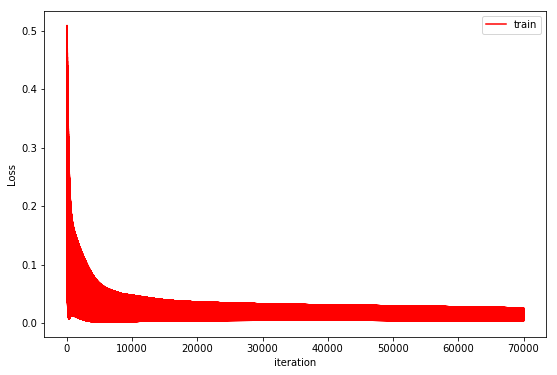

In [8]:
with tf.variable_scope('rnn', reuse=None):
    train_lstm()

In [9]:
from sklearn.metrics import mean_squared_error
import math

def prediction():
                    
        pred, _ = lstm(1)  # 预测时只输入[1,time_step,inputSize]的测试数据
        saver = tf.train.Saver(tf.global_variables())
        #预测季度
        pre_quarter = 10
        with tf.Session() as sess:
            # 参数恢复
            module_file = tf.train.latest_checkpoint("./checkpoints-lstm")
            saver.restore(sess, module_file)
            # 取训练集最后一行为测试样本. shape=[1,time_step,inputSize]
            prev_seq = train_x[-1]
            predict = []
            # 得到之后10个季度的预测结果
            for i in range(pre_quarter):
                next_seq = sess.run(pred,feed_dict={X:[prev_seq]})
                predict.append(next_seq[-1])   
                #每次得到最后一个时间步的预测结果，与之前的数据加在一起，形成新的测试样本
                #np.vstack()表示垂直（按照行顺序）的把数组给堆叠起来。
                prev_seq = np.vstack((prev_seq[1:],next_seq[-1]))
            
            #得到实际预测值
            predictY = scaler.inverse_transform(predict)
            
            testY = scaler.inverse_transform(test)
            print("预测值：", predictY)
            print("真实值：",testY )
            
            # 计算均方根误差（RMSE）
            rmse = math.sqrt(mean_squared_error(testY, predictY))
            print('Test RMSE: %.3f' % rmse)
            
            #以折线图表示结果
            plt.figure()
            plt.title("lead index")
            plt.plot(list(range(len(testY))), testY, 'cx--', list(range(len(predict))), predictY, 'b--')
            plt.xlabel("date-num")
            plt.ylabel("index")
            plt.legend(['train', 'pred'], loc='upper right')
            plt.plot()
            plt.show()

In [10]:
with tf.variable_scope('rnn', reuse=None):
    prediction()

Tensor("rnn_2/rnn/Reshape:0", shape=(?, 5, 5), dtype=float32)


ValueError: Variable rnn/rnn/basic_lstm_cell/kernel does not exist, or was not created with tf.get_variable(). Did you mean to set reuse=None in VarScope?